In [1]:
from sklearn.mixture import GaussianMixture
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

In [ ]:
#%cd ..

/content/drive/My Drive/GitHub/master-thesis


# Import Data

In [5]:
df, answers, info_dict = get_cluster_input_data(pca_data=True)
df.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,Q14_ocupation_employee_private,Q14_ocupation_unemployed,Q14_ocupation_employee_public,Q14_ocupation_self_employed,Q14_ocupation_student,Q14_ocupation_other,Q15_economic_spectrum,Q15_social_spectrum,Q16_economic_spectrum,Q16_social_spectrum
0,-0.699479,-0.770944,-0.628573,-1.347859,-0.362089,1.003139,-0.011299,0.133365,1.154861,-0.111807,...,0,0,1,0,0,0,2.0,4.0,4.0,2.0
1,-1.042685,0.134720,-0.322130,1.520663,-1.429726,0.553071,-1.170322,-1.384575,-1.049615,0.161217,...,0,0,1,0,0,0,2.0,4.0,2.0,4.0
2,-1.090649,0.528105,0.389838,1.141938,1.297194,-1.068319,-0.257879,-0.794440,-0.420931,1.823400,...,0,0,1,0,0,0,NaN,NaN,NaN,NaN
3,0.103301,-1.561799,1.319970,-0.147182,2.345984,1.095251,0.345532,-2.371791,-1.517903,-0.073005,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
4,1.908322,-1.268602,4.034475,-0.402159,0.807604,-0.425695,-1.042586,-1.173911,0.550262,1.374492,...,0,0,0,0,0,1,2.0,4.0,NaN,NaN


In [6]:
info_dict

{'cluster_input_cols': ['PC_0',
  'PC_1',
  'PC_2',
  'PC_3',
  'PC_4',
  'PC_5',
  'PC_6',
  'PC_7',
  'PC_8',
  'PC_9',
  'PC_10'],
 'data_path': 'data/preprocessing/dim_reduction/220324_pca_data.csv',
 'pca_data': True,
 'scaler_type': 'MinMaxScaler()'}

In [7]:
answers_sampled = pd.DataFrame(answers).sample(10000).to_numpy()

# GM clustering

## Elbow approach to determine ideal amount of clusters

In [ ]:
# Set up a range of cluster numbers to try
n_range = range(2,15)

# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in tqdm(n_range):
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=6)
    gm.fit(answers_sampled)
    cluster_labels = gm.predict(answers_sampled)
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(answers_sampled))
    aic_score.append(gm.aic(answers_sampled))

100%|██████████| 13/13 [03:15<00:00, 15.04s/it]


Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

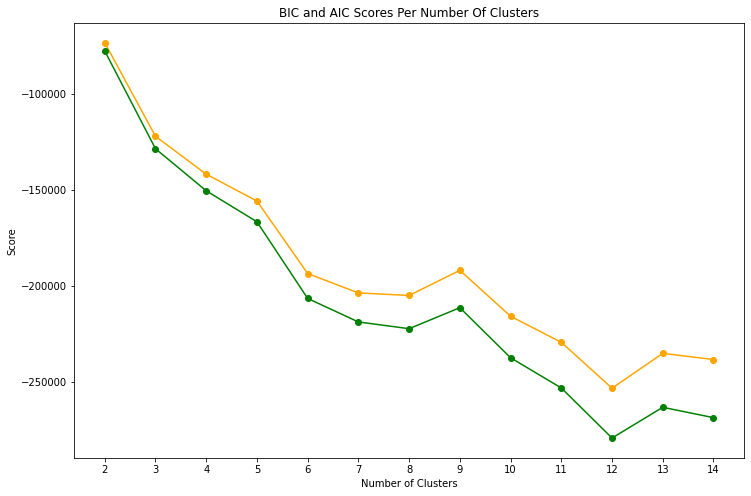

In [ ]:
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

## Probabilistic Approach to determine number of clusters

In [8]:
from scipy.stats import norm
mean = 2
std = 3
prior_dist = norm(loc=mean, scale=std)

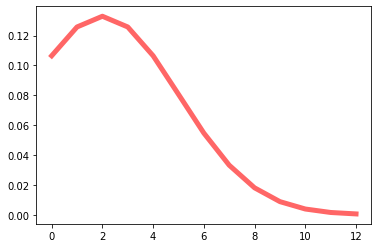

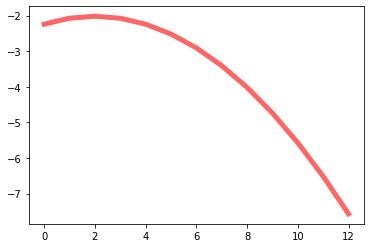

In [9]:
x = np.arange(13)
plt.plot(x, prior_dist.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()
plt.plot(x, prior_dist.logpdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

In [10]:
# Set up a range of cluster numbers to try
n_range = range(2,15)
list_log_prob_data_given_model = []
list_log_prob_model = []
list_score = []

# Loop through the range and fit a model
for n in tqdm(n_range):
    # init & fit gmm
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=6)
    gm.fit(answers_sampled)
    
    # Calculate Log Probabilities
    log_prob_data_given_model = gm.score(answers_sampled) # Computes the per-sample average log-likelihood of the given data X
    log_prob_model = prior_dist.logpdf(n)
    score = log_prob_data_given_model + log_prob_model

    # Append values to list
    list_log_prob_data_given_model.append(log_prob_data_given_model)
    list_log_prob_model.append(log_prob_model)
    list_score.append(score)



100%|██████████| 13/13 [02:23<00:00, 11.06s/it]


Text(0.5, 1.0, 'Probabilistic Evaluation')

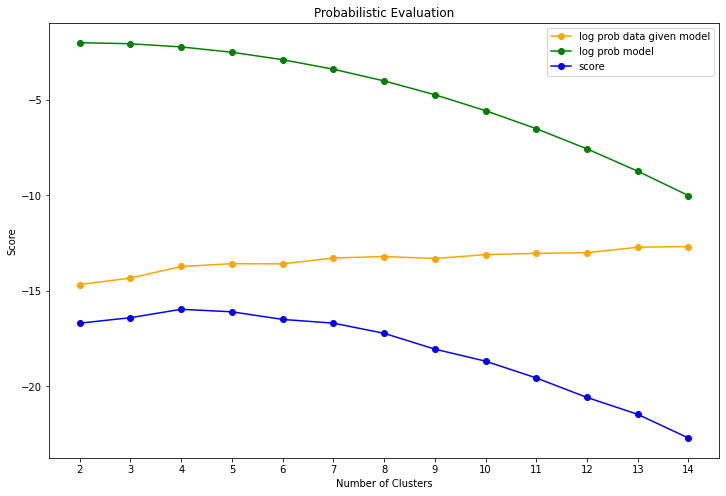

In [11]:
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, list_log_prob_data_given_model, '-o', color='orange', label='log prob data given model')
ax.plot(n_range, list_log_prob_model, '-o', color='green', label='log prob model')
ax.plot(n_range, list_score, '-o', color='blue', label='score')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.legend()
ax.set_title('Probabilistic Evaluation')

In [12]:
list_score

[-16.68869570829819,
 -16.400976421934896,
 -15.96261063326876,
 -16.094681320225686,
 -16.493130489628967,
 -16.6867638555347,
 -17.2198914722051,
 -18.046759891938752,
 -18.676862146272832,
 -19.554600582928252,
 -20.574086956191536,
 -21.457101722411696,
 -22.6966807873782]

In [13]:
n_clusters = n_range[np.argmax(list_score)]
n_clusters

4

## GM fit

In [14]:
n_clusters = 2
gm = GaussianMixture(n_components=n_clusters, 
                         random_state=123, 
                         n_init=6)
gm.fit(answers)

GaussianMixture(n_components=2, n_init=6, random_state=123)

In [15]:
df['group'] = gm.predict(answers)
df['group_prob'] = pd.DataFrame(gm.predict_proba(answers)).max(axis=1)
df.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,Q14_ocupation_employee_public,Q14_ocupation_self_employed,Q14_ocupation_student,Q14_ocupation_other,Q15_economic_spectrum,Q15_social_spectrum,Q16_economic_spectrum,Q16_social_spectrum,group,group_prob
0,-0.699479,-0.770944,-0.628573,-1.347859,-0.362089,1.003139,-0.011299,0.133365,1.154861,-0.111807,...,1,0,0,0,2.0,4.0,4.0,2.0,1,0.979111
1,-1.042685,0.134720,-0.322130,1.520663,-1.429726,0.553071,-1.170322,-1.384575,-1.049615,0.161217,...,1,0,0,0,2.0,4.0,2.0,4.0,1,0.989895
2,-1.090649,0.528105,0.389838,1.141938,1.297194,-1.068319,-0.257879,-0.794440,-0.420931,1.823400,...,1,0,0,0,NaN,NaN,NaN,NaN,0,1.000000
3,0.103301,-1.561799,1.319970,-0.147182,2.345984,1.095251,0.345532,-2.371791,-1.517903,-0.073005,...,0,0,0,0,NaN,NaN,NaN,NaN,0,1.000000
4,1.908322,-1.268602,4.034475,-0.402159,0.807604,-0.425695,-1.042586,-1.173911,0.550262,1.374492,...,0,0,0,1,2.0,4.0,NaN,NaN,0,1.000000


## Save for general clustering evaluation

In [16]:
df.to_csv('data/clustering/220323_gmm_clustered_pca_2cluster.csv', index=False)

# Specific Clustering Method Analysis

In [ ]:
gm.weights_

array([0.28843901, 0.44322344, 0.26833755])

In [ ]:
df['group'].value_counts(dropna=False)

1    54541
0    36294
2    31994
Name: group, dtype: int64

## Group Probability

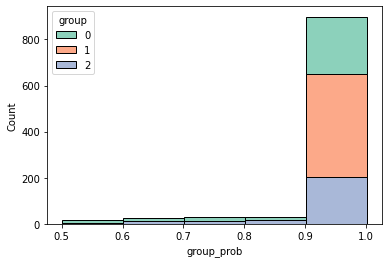

In [ ]:
df_sample = df.sample(1000)
sns.histplot(data=df_sample, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
plt.show()

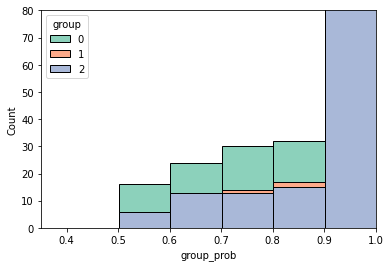

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data=df_sample, ax=ax, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
ax.set_xlim(0.35, 1)
ax.set_ylim(0,80)
plt.show()

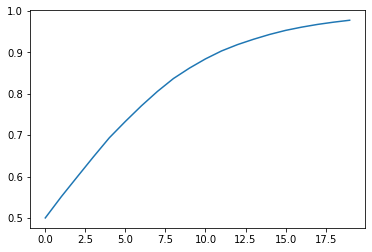

In [ ]:
prob_list = []
for i in np.arange(0, 0.2, 0.01):
  prob = df['group_prob'].quantile(i)
  prob_list.append(prob)

plt.plot(prob_list)
plt.show()